## Import

In [12]:
from gemseo import generate_coupling_graph
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo.algos.design_space import DesignSpace
from gemseo.algos.parameter_space import ParameterSpace
from gemseo_umdo.formulations.sampling_settings import Sampling_Settings
from gemseo_umdo.scenarios.umdo_scenario import UMDOScenario

## Discipline

In [13]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [14]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

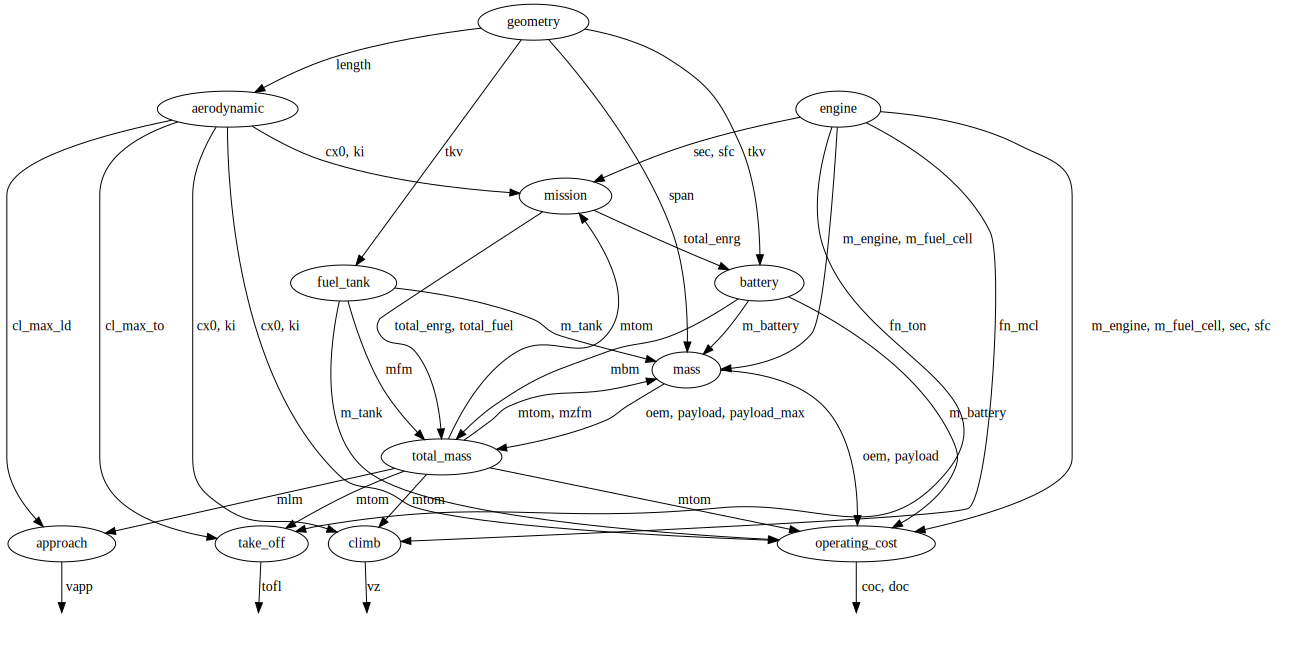

In [15]:
generate_coupling_graph(disciplines)

## Design Space

In [16]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [17]:
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs
design_space = DesignSpace()
design_space.add_variable("slst", lower_bound=convert_from("kN", 100), upper_bound=convert_from("kN", 200), value=convert_from("kN", 150))
design_space.add_variable("n_pax", lower_bound=120, upper_bound=180, value=150)
design_space.add_variable("area", lower_bound=convert_from("m2", 100), upper_bound=convert_from("m2", 200), value=convert_from("m2", 180))
design_space.add_variable("ar", lower_bound=5, upper_bound=20, value=9)

x_def={'fuel_type':'liquid_h2','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("gi","OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi","OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)
uncertain_space.add_random_variable("aef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)

## Scenario

In [18]:
scenario = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    "Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(n_samples=20)#TaylorPolynomial_Settings()#Sampling_Settings(n_samples=20),
)

In [19]:
scenario.add_constraint("tofl", "Margin", factor=3.0,constraint_type="ineq", positive=False, value=1900.)
scenario.add_constraint("vapp","Margin", factor=3.0, constraint_type="ineq", positive=False, value=convert_from('kt',135.0))
scenario.add_constraint("vz", "Margin", factor=3.0,constraint_type="ineq", positive=True, value=convert_from('ft/min',300.0))
scenario.add_constraint("span", "Margin", factor=3.0, constraint_type="ineq", positive=False, value=40.0)
scenario.add_constraint("length", "Margin", factor=3.0,constraint_type="ineq", positive=False, value=45.0)
scenario.add_constraint("fm", "Margin", factor=3.0,constraint_type="ineq", positive=True, value=0.0)



In [20]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)


    INFO - 16:32:44: *** Start UMDOScenario execution ***
    INFO - 16:32:44: UMDOScenario
    INFO - 16:32:44:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 16:32:44:    Formulation:
    INFO - 16:32:44:       MDO formulation: MDF
    INFO - 16:32:44:       Statistic estimation: Sampling
    INFO - 16:32:44:    Uncertain space:
    INFO - 16:32:44:       +------+------------------------------------------------+
    INFO - 16:32:44:       | Name |                  Distribution                  |
    INFO - 16:32:44:       +------+------------------------------------------------+
    INFO - 16:32:44:       |  gi  | Triangular(lower=0.35, mode=0.4, upper=0.405)  |
    INFO - 16:32:44:       |  vi  | Triangular(lower=0.755, mode=0.8, upper=0.805) |
    INFO - 16:32:44:       | aef  |  Triangular(lower=0.99, mode=1.0, upper=1.03)  |
    INFO - 16:32:44:       | cef  |  Triangular(lower=0.99, mode=1.0

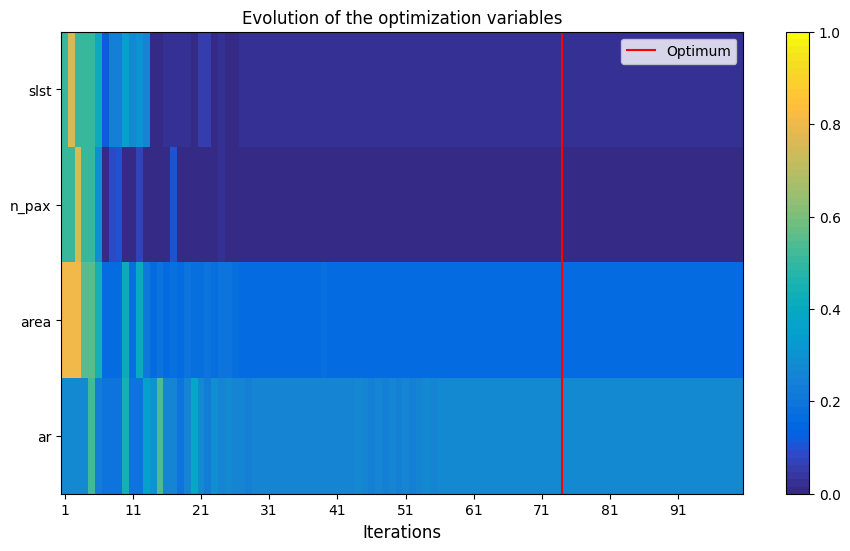

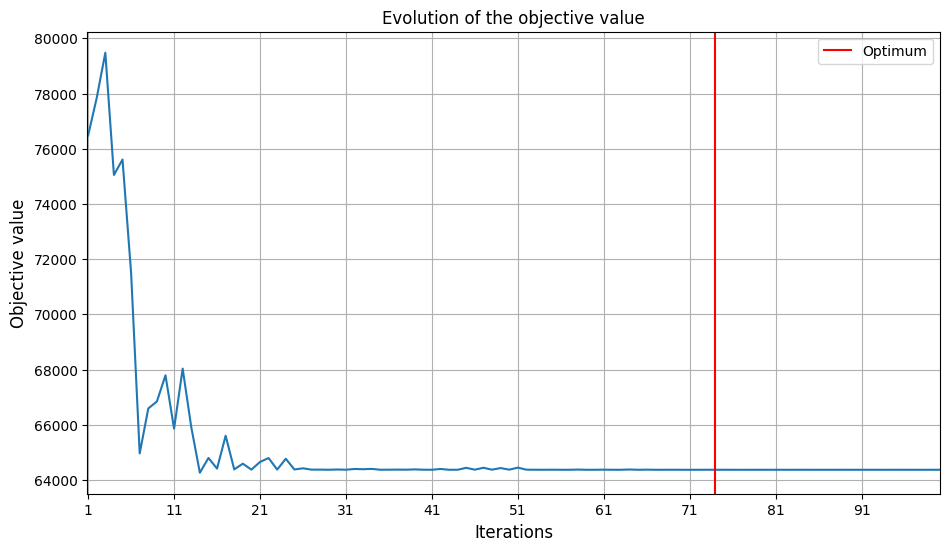

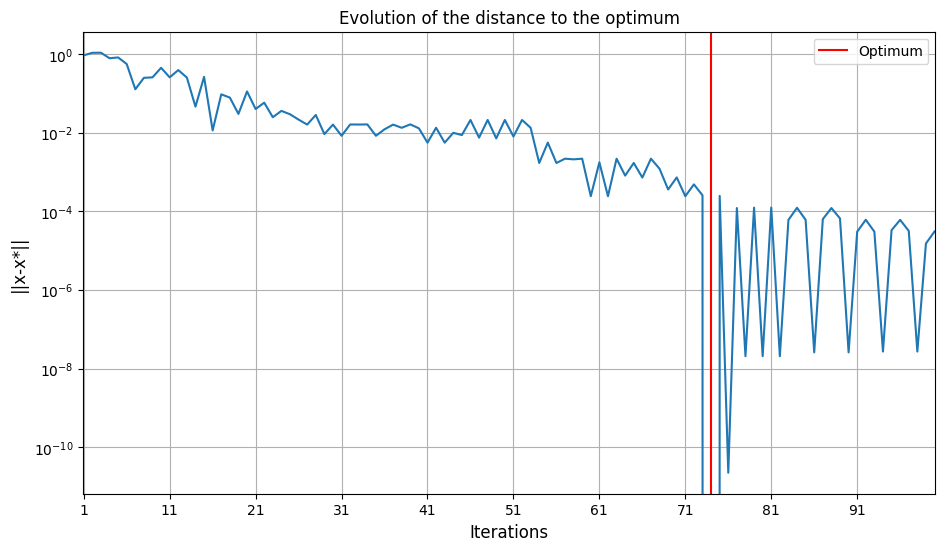

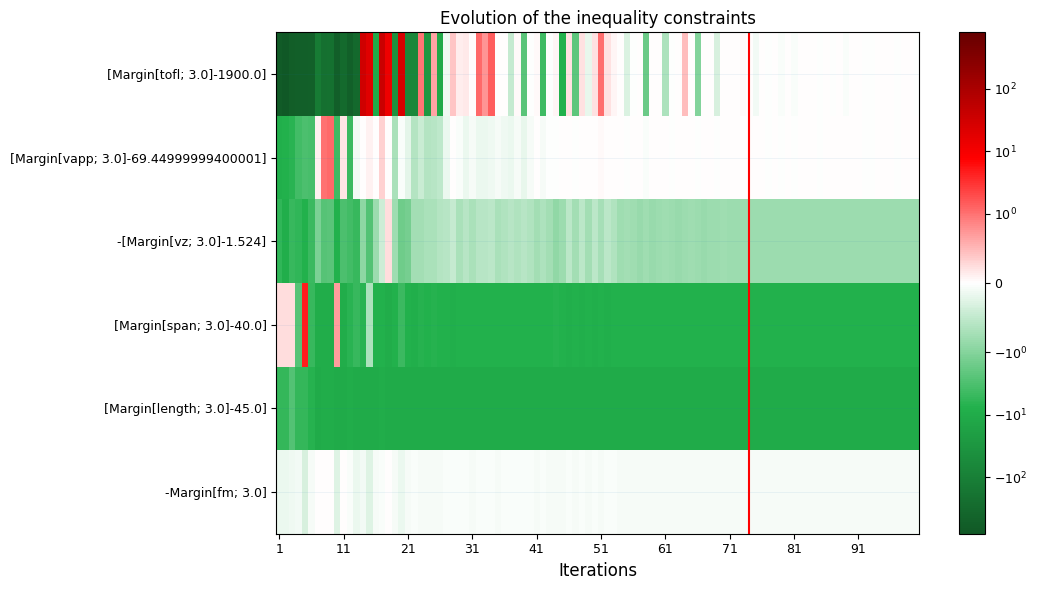

In [21]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)


# Visualisation de l'avion final

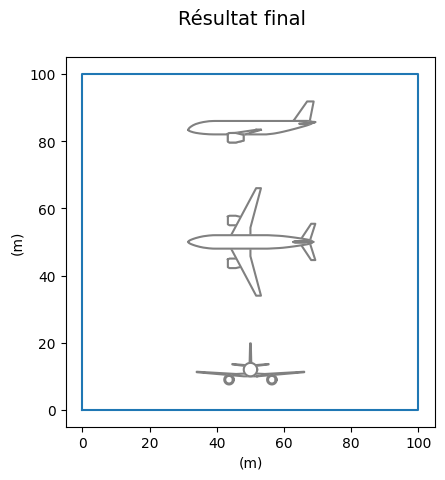

In [22]:
from gemseo_oad_training.utils import draw_aircraft
dict_result = scenario.optimization_result.x_opt_as_dict
draw_aircraft(area=dict_result["area"][0],slst=dict_result["slst"][0], n_pax=dict_result["n_pax"][0], title="Résultat final")